# Two KDD comparison, 3D, using profiles

We're going to conpare R5 machine (UMMC with GP2 phase space file)  and RX (experimental) machine which has GP3 style source with GP2 collimators. Both used the same L08 cup, R5 was computed with 100,000,000 tracks while RX was computed with 200,000,000 tracks. QA cups were always compiled with 200,000,000 tracks.

In [1]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path

from scipy.interpolate import RegularGridInterpolator

%matplotlib inline

Selecting reference and evaluation kernels to compare. Reference is R5 machine kernel, while evaluation is RX machine kernel. Same shot position and same collimator to be used, though we don't check it for a time being.

In [2]:
# kernels to compare
path2dosedata = Path("D:/XCSW/")

kdd_reference = path2dosedata / "XcDoseData/R5/PlanEngineResource/R5/Kdd/R5O0IQ00_Y000Z061C015.d3d"
kdd_evaluated = path2dosedata / "XcDoseData/RX/PlanEngineResource/RX/Kdd/RXO0IQ00_Y000Z061C015.d3d"

print("Looking to compare \nreference: {0}\n                     with \nevaluated: {1}\n".format(kdd_reference, kdd_evaluated))

if (os.path.exists(kdd_reference)):
    print("Found reference dose file")
else:
    raise RuntimeError("Reference dose file not found")
    
if (os.path.exists(kdd_evaluated)):
    print("Found evaluated dose file")
else:
    raise RuntimeError("Evaluated dose file not found")


# should read it from the kernels
y_shot = 0.0
z_shot = 0.0

print("\nShot position (Y,Z): {0} mm, {1} mm".format(y_shot, z_shot))

Looking to compare 
reference: D:\XCSW\XcDoseData\R5\PlanEngineResource\R5\Kdd\R5O0IQ00_Y000Z061C015.d3d
                     with 
evaluated: D:\XCSW\XcDoseData\RX\PlanEngineResource\RX\Kdd\RXO0IQ00_Y000Z061C015.d3d

Found reference dose file
Found evaluated dose file

Shot position (Y,Z): 0.0 mm, 0.0 mm


# Loading Data

## Helper code to load KDDs from binary files

In [3]:
def remake_boundary(f, n: int, sym: bool):
    """
    Given filestream f and number of points n and symmetry flag sym,
    remake the boundary array
    """
    b = np.empty(n + 1, dtype = np.float32)

    for k in range(0, n + 1):
        b[k] = struct.unpack('f', f.read(4))[0]
        
    # here might be code to expand symmetric boundary array

    return b


def readKDD(fname: str):
    """
    Given the file name, read and return data from KDD file
    """
    with open(fname, mode='rb') as f: # b is important -> binary

        # read header, 8*int32, non-relevant information
        h0 = struct.unpack('i', f.read(4))[0]
        h1 = struct.unpack('i', f.read(4))[0]
        h2 = struct.unpack('i', f.read(4))[0]
        h3 = struct.unpack('i', f.read(4))[0]
        h4 = struct.unpack('i', f.read(4))[0]
        h5 = struct.unpack('i', f.read(4))[0]
        h6 = struct.unpack('i', f.read(4))[0]
        h7 = struct.unpack('i', f.read(4))[0]

        # symmetry flags
        xsym = True if struct.unpack('i', f.read(4))[0] != 0 else False
        ysym = True if struct.unpack('i', f.read(4))[0] != 0 else False
        zsym = True if struct.unpack('i', f.read(4))[0] != 0 else False

        # read in nx, ny, and nz, numbers being number of voxels/pixels for X, Y, Z
        nx = struct.unpack('i', f.read(4))[0]
        ny = struct.unpack('i', f.read(4))[0]
        nz = struct.unpack('i', f.read(4))[0]

        # create boundary arrays, read in the boundaries, each one will have size n(x|y|z)+1
        xBoundary = remake_boundary(f, nx, xsym)
        yBoundary = remake_boundary(f, ny, ysym)
        zBoundary = remake_boundary(f, nz, zsym)

        #create dose matrix
        dose = np.empty((nx, ny, nz), dtype = np.float32)

        #read in the dose matrix
        for ix in range(0, nx):
            for iy in range(0, ny):
                for iz in range(0, nz):
                    dose[ix, iy, iz] = struct.unpack('f', f.read(4))[0]

        return (xsym, ysym, zsym, nx, ny, nz, xBoundary, yBoundary, zBoundary, dose)

    return None


def make_grid_from_boundary(b):
    """
    Given boundaries, make grid with points in-between boundaries
    """    
    n = b.shape[0]
    g = np.empty(n - 1, dtype=np.float32)
    
    b_prev = b[0]
    for k in range(0, n-1):
        b_next = b[k+1]
        g[k]   = np.mean((b_prev, b_next))
        b_prev = b_next
        
    return g

# Check files, read doses, boundaries and symmetry flags

In [4]:
xs_ref, ys_ref, zs_ref, _, _, _, xb_ref, yb_ref, zb_ref, dose_reference = readKDD(kdd_reference)
xs_evl, ys_evl, zs_evl, _, _, _, xb_evl, yb_evl, zb_evl, dose_evaluated = readKDD(kdd_evaluated)

x_reference = make_grid_from_boundary(xb_ref)
y_reference = make_grid_from_boundary(yb_ref)
z_reference = make_grid_from_boundary(zb_ref)

x_evaluated = make_grid_from_boundary(xb_evl)
y_evaluated = make_grid_from_boundary(yb_evl)
z_evaluated = make_grid_from_boundary(zb_evl)

print("Reference  dose dimensions: {0} {1} {2}".format(len(x_reference), len(y_reference), len(z_reference)))
print("Evaluation dose dimensions: {0} {1} {2}\n".format(len(x_evaluated), len(y_evaluated), len(z_evaluated)))
print("Reference  dose symmetry flags: {0} {1} {2}".format(xs_ref, ys_ref, zs_ref))
print("Evaluation dose symmetry flags: {0} {1} {2}".format(xs_evl, ys_evl, zs_evl))
#print(yb_ref)

Reference  dose dimensions: 60 120 106
Evaluation dose dimensions: 60 120 106

Reference  dose symmetry flags: True False False
Evaluation dose symmetry flags: True False False


## Normalization

First, we're looking at max dose value and position. NB, both dose grids are X symmetrised. X is direction orthogonal to shot plane. Y axis is cup radial coordinate. Z axis is aligned with cup axis.

In [5]:
idx_ref        = np.unravel_index(np.argmax(dose_reference, axis=None), dose_reference.shape)
dmax_reference = dose_reference[idx_ref]

idx_evl        = np.unravel_index(np.argmax(dose_evaluated, axis=None), dose_evaluated.shape)
dmax_evaluated = dose_evaluated[idx_evl]

ratio = dmax_evaluated / dmax_reference
print("Point doses, Dmax_ref = {0}, Dmax_eval = {1} (Gy/photon), ratio = {2}".format(dmax_reference, dmax_evaluated, ratio))
print("Dmax_ref was found at {0}".format(idx_ref))
print("Dmax_evl was found at {0}".format(idx_evl))

Point doses, Dmax_ref = 1.6497443661479274e-16, Dmax_eval = 1.260525050648492e-16 (Gy/photon), ratio = 0.7640729546546936
Dmax_ref was found at (3, 60, 55)
Dmax_evl was found at (0, 61, 57)


Now, averaged dose at the center of the shot. NB, we use 2 voxels average in Y and Z, but only one in X because of symmetrization, thus making using X already averaged.

In [6]:
def find_center_indices(bnd, d_small, d_large):
    """
    given boundaries array bnd, and small and larve voxel size, find
    low and high values separating fine area from mean area
    """
    n = len(bnd)
    
    # find smallest left
    idx_left = -999
    for k in range(0, n-1):
        if np.absolute(bnd[k+1] - bnd[k] - d_large) < 0.01:
            continue
        if np.absolute(bnd[k+1] - bnd[k] - d_small) < 0.01:
            idx_left = k
            break
            
    # find largest right
    idx_rght = -999
    for k in range(n-1, 0, -1):
        if np.absolute(bnd[k] - bnd[k-1] - d_large) < 0.01:
            continue
        if np.absolute(bnd[k] - bnd[k-1] - d_small) < 0.01:
            idx_rght = k
            break
        
    return (idx_left, idx_rght)

def find_dmax_avg(plane, np0, np1):
    """
    Given 2D plane, find averaged max dose patch and indices of patch start
    np0 and np1 define size of the patch
    """
    ny = plane.shape[0]
    nz = plane.shape[1]
    
    ymax = -999
    zmax = -999
    dmax = np.float32(-1)
    for iy in range(0, ny-(np0-1)):
        for iz in range(0, nz-(np1-1)):
            d = np.mean(plane[iy:iy+np0, iz:iz+np1])
            if d > dmax:
                dmax = d
                ymax = iy
                zmax = iz
                
    return (ymax, zmax, dmax)
    
dmax_ref = find_dmax_avg(dose_reference[0,:,:], 2, 2)
dmax_evl = find_dmax_avg(dose_evaluated[0,:,:], 2, 2)
print("Reference maximum averaged over 2 voxels dose: {0}".format(dmax_ref))
print("Evaluated maximum averaged over 2 voxels dose: {0}".format(dmax_evl))
print(dmax_evl[2]/dmax_ref[2])

Reference maximum averaged over 2 voxels dose: (58, 56, 1.623264e-16)
Evaluated maximum averaged over 2 voxels dose: (60, 56, 1.2440655e-16)
0.7663975


# Comparing reference and evaluated dose

## Rescale reference and evaluated dose

In [7]:
# rescaling to 1, or to KddScalar ?
dose_reference = dose_reference / dmax_ref[2]
dose_evaluated = dose_evaluated / dmax_evl[2]
print("Maximum point dose relative to maximum averaged dose")
print("Dmax_ref = {0}, Dmax_eval = {1} (relative dose)".format(np.amax(dose_reference), np.amax(dose_evaluated)))

Maximum point dose relative to maximum averaged dose
Dmax_ref = 1.016313076019287, Dmax_eval = 1.0132304430007935 (relative dose)


Very little diference betwen peak dose and averaged max dose. Now doses are scaled to about 1, and we could draw and compare them together.

## Plane X cut, at X = 0 (averaged due to symmetry flag), reference vs evaluation

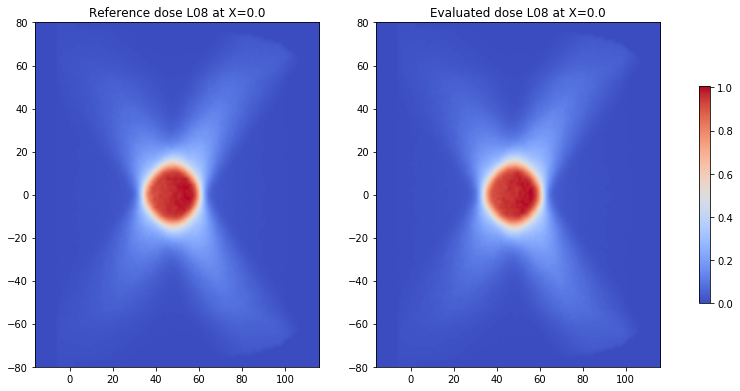

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,8))

im = axes[0].imshow(dose_reference[0,:,:],  interpolation='bilinear', cmap = cm.coolwarm, origin='lower',
                    extent=[zb_ref[0], zb_ref[-1], yb_ref[0], yb_ref[-1]])
axes[0].set_title("Reference dose L08 at X=0.0")

clim = im.properties()['clim']
axes[1].imshow(dose_evaluated[0,:,:], clim = clim,  interpolation='bilinear', cmap = cm.coolwarm, origin='lower',
               extent=[zb_evl[0], zb_evl[-1], yb_evl[0], yb_evl[-1]])
axes[1].set_title("Evaluated dose L08 at X=0.0")

fig.colorbar(im, ax = axes. ravel().tolist(), shrink=0.5)

Dose distributions looks reasonable similar. NB! Reference dose has more noise (100mln tracks) relative to evaluated dose (200mln tracks).

Let's plot dose differences in the same plane - (reference-evaluated) and (evaluated-reference)

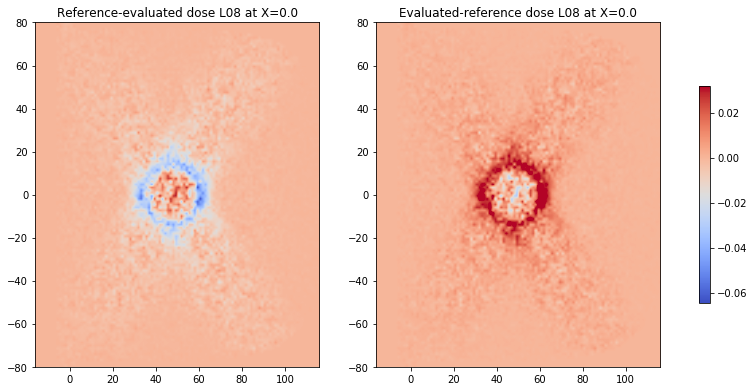

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,8))

im = axes[0].imshow(dose_reference[0,:,:] - dose_evaluated[0,:,:],  interpolation='bilinear', cmap = cm.coolwarm,
                    origin='lower',
                    extent=[zb_evl[0], zb_evl[-1], yb_evl[0], yb_evl[-1]])
axes[0].set_title("Reference-evaluated dose L08 at X=0.0")

clim = im.properties()['clim']
axes[1].imshow(dose_evaluated[0,:,:] - dose_reference[0,:,:], clim = clim,  interpolation='bilinear', cmap = cm.coolwarm,
                    origin='lower',
                    extent=[zb_evl[0], zb_evl[-1], yb_evl[0], yb_evl[-1]])
axes[1].set_title("Evaluated-reference dose L08 at X=0.0")

fig.colorbar(im, ax = axes. ravel().tolist(), shrink=0.5)

Here we observe visible difference in the outer penumbra area of the dose distribution

# Plane cut through reference dmax at Yi = -1.2...1.2 mm, averaged over two slices

Dose in the Y range [-2.0...0.0]


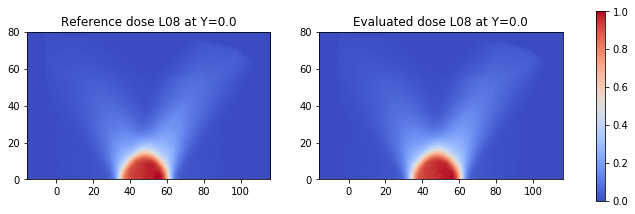

In [10]:
print("Dose in the Y range [{0}...{1}]".format(yb_ref[dmax_ref[0]], yb_ref[dmax_ref[0]+2]))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,7))

plane_ref = np.mean(dose_reference[:,dmax_ref[0]:dmax_ref[0]+2,:], axis=1)
im = axes[0].imshow(plane_ref, interpolation='bilinear', cmap = cm.coolwarm,
                    origin='lower',
                    extent=[zb_ref[0], zb_ref[-1], xb_ref[0], xb_ref[-1]])
axes[0].set_title("Reference dose L08 at Y=0.0")

clim = im.properties()['clim']

plane_evl = np.mean(dose_evaluated[:,dmax_ref[0]:dmax_ref[0]+2,:], axis=1)
axes[1].imshow(plane_evl, clim = clim,  interpolation='bilinear', cmap = cm.coolwarm,
                    origin='lower',
                    extent=[zb_evl[0], zb_evl[-1], xb_evl[0], xb_evl[-1]])               
axes[1].set_title("Evaluated dose L08 at Y=0.0")

fig.colorbar(im, ax = axes. ravel().tolist(), shrink=0.5)


Close looking dose distributions. Again, lets try to substract one from another

Dose in the Y range [-2.0...0.0]


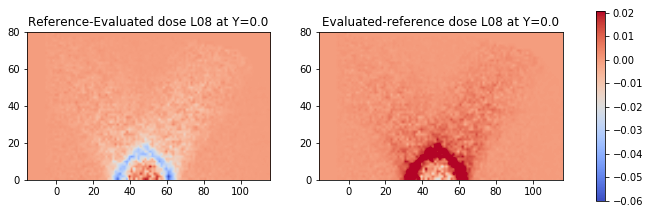

In [11]:
print("Dose in the Y range [{0}...{1}]".format(yb_ref[dmax_ref[0]], yb_ref[dmax_ref[0]+2]))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,7))

plane_ref = np.mean(dose_reference[:,dmax_ref[0]:dmax_ref[0]+2,:], axis=1)
plane_evl = np.mean(dose_evaluated[:,dmax_ref[0]:dmax_ref[0]+2,:], axis=1)
im = axes[0].imshow(plane_ref - plane_evl, interpolation='bilinear', cmap = cm.coolwarm,
                    origin='lower',
                    extent=[zb_ref[0], zb_ref[-1], xb_ref[0], xb_ref[-1]])
axes[0].set_title("Reference-Evaluated dose L08 at Y=0.0")

clim = im.properties()['clim']

axes[1].imshow(plane_evl - plane_ref, clim = clim,  interpolation='bilinear', cmap = cm.coolwarm,
                    origin='lower',
                    extent=[zb_evl[0], zb_evl[-1], xb_evl[0], xb_evl[-1]])               
axes[1].set_title("Evaluated-reference dose L08 at Y=0.0")

fig.colorbar(im, ax = axes. ravel().tolist(), shrink=0.5)


Again, here we observe visible difference in the outer penumbra area of the dose distribution

# Plane cut through reference dmax at Z = 9.6...12 mm, averaged over two slices

Dose in the Z range [-4.0...-2.0]


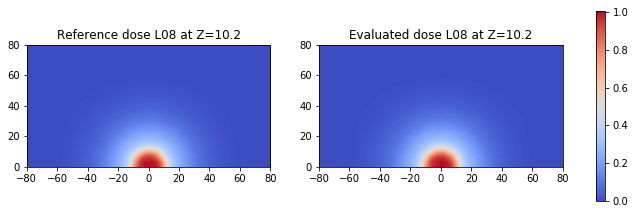

In [12]:
print("Dose in the Z range [{0}...{1}]".format(yb_ref[dmax_ref[1]], yb_ref[dmax_ref[1]+2]))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,7))

plane_ref = np.mean(dose_reference[:,:,dmax_ref[1]:dmax_ref[1]+2], axis=2)
im = axes[0].imshow(plane_ref, interpolation='bilinear', cmap = cm.coolwarm,
                    origin='lower',
                    extent=[yb_ref[0], yb_ref[-1], xb_ref[0], xb_ref[-1]])                                   
axes[0].set_title("Reference dose L08 at Z=10.2")

clim = im.properties()['clim']

plane_evl = np.mean(dose_evaluated[:,:,dmax_ref[1]:dmax_ref[1]+2], axis=2)
axes[1].imshow(plane_evl, clim = clim,  interpolation='bilinear', cmap = cm.coolwarm,
                    origin='lower',
                    extent=[yb_evl[0], yb_evl[-1], xb_evl[0], xb_evl[-1]])                                                  
axes[1].set_title("Evaluated dose L08 at Z=10.2")

fig.colorbar(im, ax = axes. ravel().tolist(), shrink=0.5)

Close looking dose distributions. Again, plotting differences.

Dose in the Z range [-4.0...-2.0]


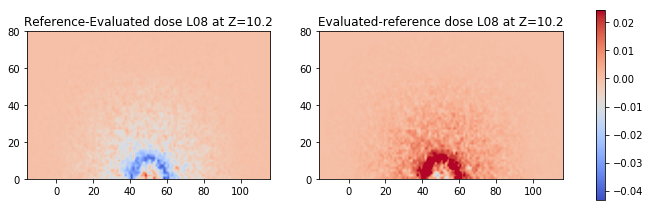

In [13]:
print("Dose in the Z range [{0}...{1}]".format(yb_ref[dmax_ref[1]], yb_ref[dmax_ref[1]+2]))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,7))

plane_ref = np.mean(dose_reference[:,:,dmax_ref[1]:dmax_ref[1]+2], axis=2)
plane_evl = np.mean(dose_evaluated[:,:,dmax_ref[1]:dmax_ref[1]+2], axis=2)
im = axes[0].imshow(plane_ref - plane_evl, interpolation='bilinear', cmap = cm.coolwarm,
                    origin='lower',
                    extent=[zb_evl[0], zb_evl[-1], xb_evl[0], xb_evl[-1]])                                   
axes[0].set_title("Reference-Evaluated dose L08 at Z=10.2")

clim = im.properties()['clim']

axes[1].imshow(plane_evl - plane_ref, clim = clim,  interpolation='bilinear', cmap = cm.coolwarm,
                    origin='lower',
                    extent=[zb_evl[0], zb_evl[-1], xb_evl[0], xb_evl[-1]])                                                  
axes[1].set_title("Evaluated-reference dose L08 at Z=10.2")

fig.colorbar(im, ax = axes. ravel().tolist(), shrink=0.5)

Conclusion: while there are visile differences on the 2D dose distributions, they are in far penumbra region and typically around 2-3%. We most likely to get away from needing new source files. The only correction most likely to be done is related to lower per-decay intensity of the new evaluated dose. That could be done via KddScalar correction.

# Profiles through center, along X, Y, Z axes, averaged by 2x2 block

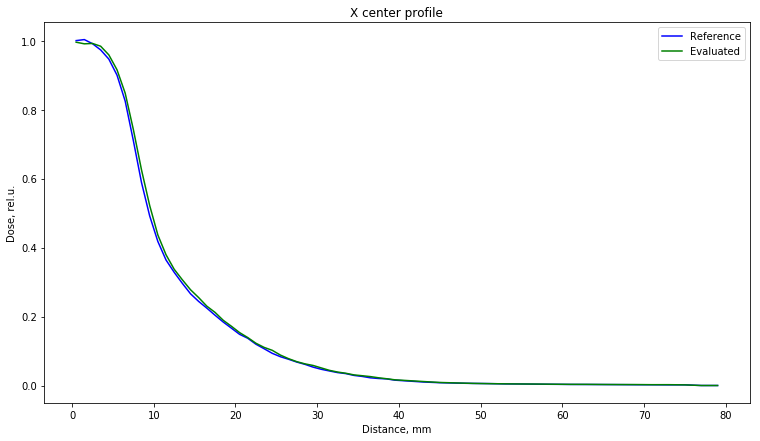

In [14]:
fig = plt.figure(figsize=(14,7))
fig.subplots_adjust(left=0.2, wspace=0.3)

px_ref = np.mean(dose_reference[:, dmax_ref[0]:dmax_ref[0]+2, dmax_ref[1]:dmax_ref[1]+2], axis=(1,2))
px_evl = np.mean(dose_evaluated[:, dmax_ref[0]:dmax_ref[0]+2, dmax_ref[1]:dmax_ref[1]+2], axis=(1,2))
ax_x = fig.add_subplot(111)
ax_x.plot(x_reference, px_ref, 'b-', label='Reference')
ax_x.plot(x_reference, px_evl, 'g-', label='Evaluated')
ax_x.set_title('X center profile')
ax_x.set_xlabel('Distance, mm')
ax_x.set_ylabel('Dose, rel.u.')
ax_x.legend()

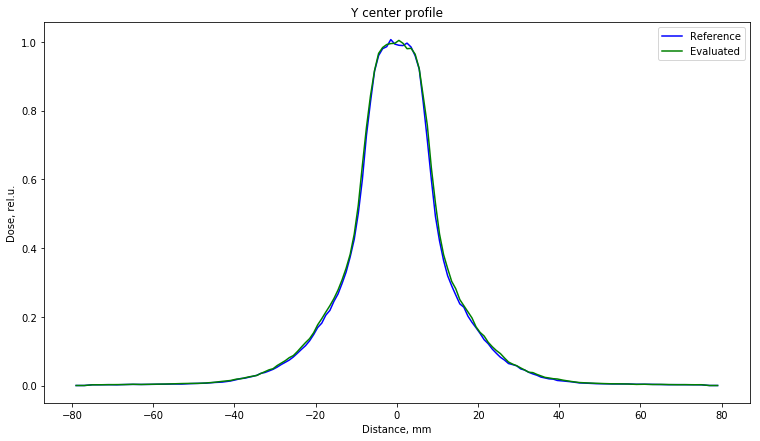

In [15]:
fig = plt.figure(figsize=(14,7))
fig.subplots_adjust(left=0.2, wspace=0.3)

py_ref = np.mean(dose_reference[0:1, :, dmax_ref[1]:dmax_ref[1]+2], axis=(0,2))
py_evl = np.mean(dose_evaluated[0:1, :, dmax_ref[1]:dmax_ref[1]+2], axis=(0,2))
ax_y = fig.add_subplot(111)
ax_y.plot(y_reference, py_ref, 'b-', label='Reference')
ax_y.plot(y_reference, py_evl, 'g-', label='Evaluated')
ax_y.set_title('Y center profile')
ax_y.set_xlabel('Distance, mm')
ax_y.set_ylabel('Dose, rel.u.')
ax_y.legend()

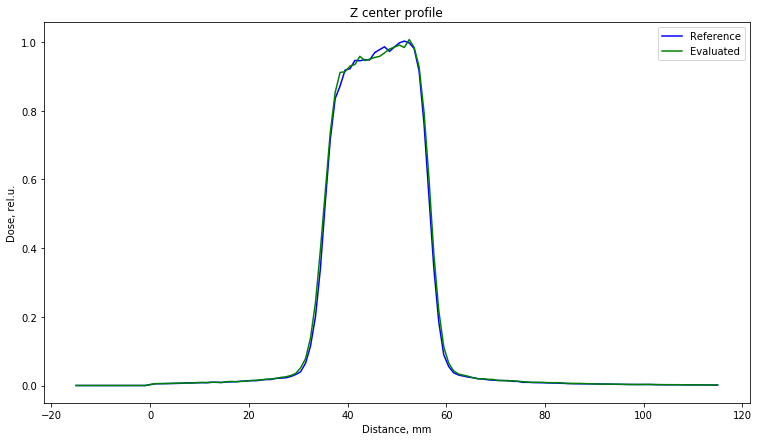

In [16]:
fig = plt.figure(figsize=(14,7))
fig.subplots_adjust(left=0.2, wspace=0.3)

pz_ref = np.mean(dose_reference[0:1, dmax_ref[0]:dmax_ref[0]+2, :], axis=(0,1))
pz_evl = np.mean(dose_evaluated[0:1, dmax_ref[0]:dmax_ref[0]+2, :], axis=(0,1))
ax_z = fig.add_subplot(111)
ax_z.plot(z_reference, pz_ref, 'b-', label='Reference')
ax_z.plot(z_reference, pz_evl, 'g-', label='Evaluated')
ax_z.set_title('Z center profile')
ax_z.set_xlabel('Distance, mm')
ax_z.set_ylabel('Dose, rel.u.')
ax_z.legend()

 # Conclusion

For QA cups the conclusion is close to what we have reached for L08 cup. In general, if we look at the core dose area, distributions are very indistinguishable from each other. Area of the penumbra is a bit different, but most likely not enough to make much difference in typical planning scenario. Scaling due to lower yield-per-decay is required, but to be done via KddScalar. We shall not for a time being continue to run GP3+GP2/s25 kernels, but use GP2/s25 kernels for all our planning activity, unless there is solid indication something is wrong and/or different.